# FSDD Digit Audio Classification using MFCCs

Code taken from https://github.com/adhishthite/sound-mnist.
You should save the GitHub repo at Jupyter folder or adjust the file paths in the code below.

In [6]:
import matplotlib.pyplot as plt
import keras
import os
import numpy as np
import librosa
import random as rn
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, \
    LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

In [14]:
dir = './recordings/'

def get_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

def wav2mfcc(file_path, max_pad_len=20):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=8000)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

def get_data():
    labels = []
    mfccs = []
    for f in os.listdir(dir):
        if f.endswith('.wav'):
            # MFCC
            mfccs.append(wav2mfcc(dir + f))
            # List of labels
            label = f.split('_')[0]
            labels.append(label)
    return np.asarray(mfccs), to_categorical(labels)

def get_all():
    mfccs, labels = get_data()
    dim_1 = mfccs.shape[1]
    dim_2 = mfccs.shape[2]
    channels = 1
    classes = 10

    X = mfccs
    X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
    y = labels
    input_shape = (dim_1, dim_2, channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
    model = get_cnn_model(input_shape, classes)
    return X_train, X_test, y_train, y_test, model

In [15]:
X_train, X_test, y_train, y_test, cnn_model = get_all()
cnn_model.summary()
cnn_model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1, validation_split=0.1)
cnn_model.save('trained_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 19, 19, 32)        160       
_________________________________________________________________
batch_normalization_21 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 18, 18, 48)        6192      
_________________________________________________________________
batch_normalization_22 (Batc (None, 18, 18, 48)        192       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 17, 17, 120)       23160     
_________________________________________________________________
batch_normalization_23 (Batc (None, 17, 17, 120)       480       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 120)         0         
__________

In [16]:
# Official way of predicting
from sklearn.metrics import classification_report
from keras.utils import to_categorical
dir = './test/'

def check_preds(X, y):
    trained_model = keras.models.load_model('trained_model.h5')
    predictions = trained_model.predict_classes(X)
    print(classification_report(y, to_categorical(predictions)))

if __name__ == '__main__':
    X_train, X_test, y_train, y_test, _ = get_all()
    check_preds(X_train, y_train)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         2
           5       1.00      1.00      1.00         2
           6       0.50      1.00      0.67         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.14      0.50      0.22         2

   micro avg       0.33      0.33      0.33        18
   macro avg       0.26      0.30      0.26        18
weighted avg       0.29      0.33      0.28        18
 samples avg       0.33      0.33      0.33        18



C:\Users\kavra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
# Another way of predicting
x = []
mfccs = []
mfccs_new = []
for f in os.listdir(dir):
    wave, sr = librosa.load(dir+f, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=8000)
    pad_width = 20 - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    mfccs.append(mfcc)
    mfccs_new.append(np.array(mfcc))

x = np.asarray(mfccs)
dim_1 = x.shape[1]
dim_2 = x.shape[2]  
x = x.reshape((x.shape[0], dim_1, dim_2, 1))
arr = cnn_model.predict(x)
for i in range(20):
    print(np.argmax(arr[i]))

4
7
9
5
9
9
6
3
9
6
5
5
6
6
9
9
9
1
8
9


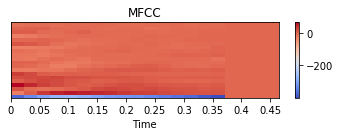

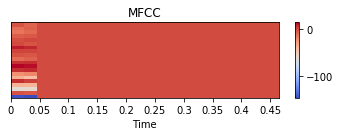

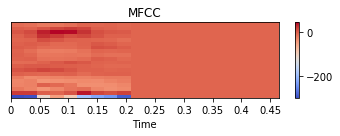

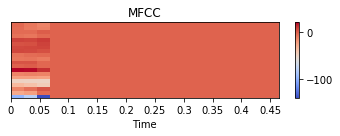

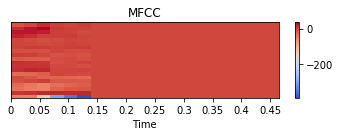

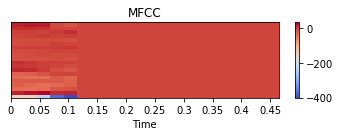

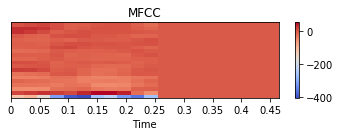

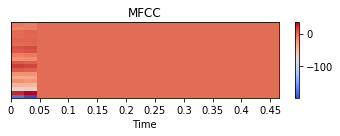

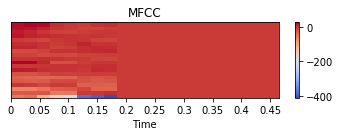

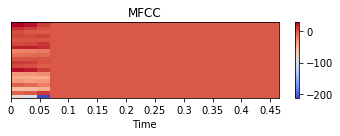

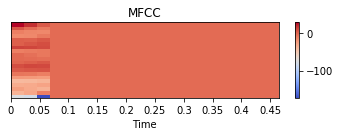

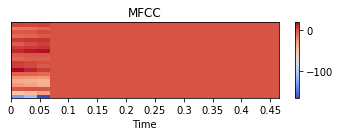

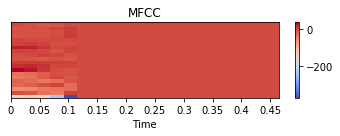

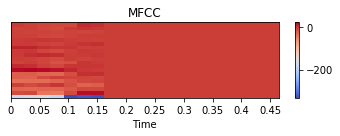

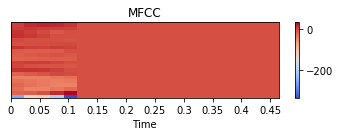

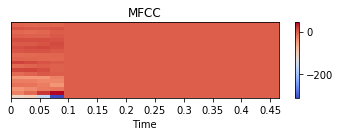

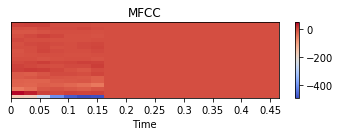

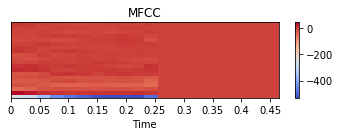

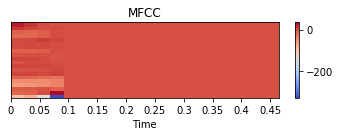

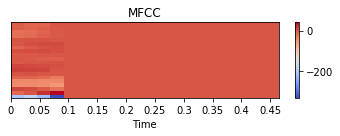

In [13]:
# MFCC plots
from librosa import display
for i in range(len(mfccs)):
    plt.figure(figsize=(5, 2))
    librosa.display.specshow(mfccs[i], x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()